In [16]:
CONTEXT = 21

In [17]:
import warnings

warnings.filterwarnings("ignore")
from zipfile import ZipFile # For reading the data from within the zip file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as ps
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from matplotlib.style import use
from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (BayesianRidge, ElasticNet, HuberRegressor,
                                  Lars, Lasso, LinearRegression, Ridge)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.utils import shuffle
from xgboost import XGBRegressor

use("ggplot")

%matplotlib inline


In [18]:
with ZipFile("data/archive.zip", 'r') as file:
	with file.open("England_Regions_COVID_Dataset.csv") as raw:
		raw = pd.read_csv(raw)

## Data Preprocessing

In [19]:
def get_cases(region) -> pd.DataFrame:
	return ps.sqldf(
	    f"""
SELECT date, areaName, newCasesByPublishDate FROM raw
WHERE areaName = "{region}"
ORDER BY date
"""
	).fillna(0)["newCasesByPublishDate"]

In [20]:
data = pd.DataFrame()
data["London"] = get_cases("London")
data["South West"] = get_cases("South West")
data["North West"] = get_cases("North West")
data["East England"] = get_cases("East of England")
data["East Midlands"] = get_cases("East Midlands")

imp = SimpleImputer(strategy="mean")
data = pd.DataFrame(imp.fit_transform(data), columns=data.columns, index=data.index)

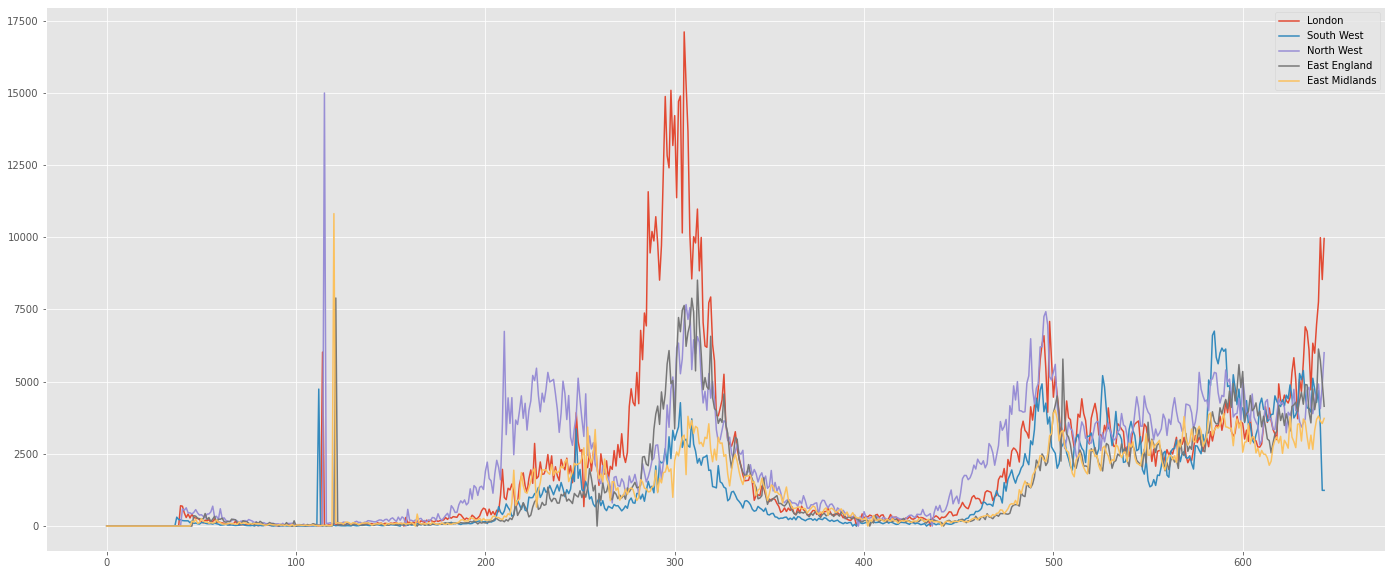

In [21]:
plt.figure(figsize=(24, 10))

for column in data:
	plt.plot(data[[column]], label=column)

plt.legend()
plt.show()

In [22]:
X = data[["London"]]

for i in range(1, CONTEXT + 1):
	X[str(i)] = X.iloc(axis=1)[-1].shift(1)

X.columns = range(CONTEXT + 1)
X = X.dropna()

y = X[CONTEXT]
X.drop(CONTEXT, axis=1, inplace=True)

X = X.values

# Models

In [23]:
X, y = shuffle(X, y)

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [25]:
def predict(model, y, x):
    predictions = np.array(
        list(
            zip(
                range(len(y)),
                np.array(sorted(list(zip(y, model.predict(x))), key=lambda x: x[1])).T[0],
                np.array(sorted(list(zip(y, model.predict(x))), key=lambda x: x[1])).T[1]
            )
        )
    ).T
    tp = str(type(model)).split(".")[-1][:-2]

    print(f"{tp} MAE: {mean_absolute_error(y, model.predict(x))}")
    return predictions

In [26]:
def get_predictions(model, X_train, X_valid, y_train, y_valid, fit_params: dict = {}, **params):
	tp = str(type(model(**params))).split(".")[-1][:-2]

	model = model(**params)
	model.fit(X_train, y_train, **fit_params)

	predictions = predict(model, y_valid, X_valid)

	plt.figure(figsize=(24, 4))

	plt.title(f"{tp}: Predictions to Targets")
	plt.scatter(predictions[0], predictions[1], label="True Values", marker="v")
	plt.scatter(predictions[0], predictions[2], label="Predicted Values", marker="x")
	plt.legend()
	plt.show()

	return model

## Model Selection: Loss

The following contains plots of the models' predictions compared to the labels of the validation data.

AdaBoostRegressor MAE: 405.51218857951835


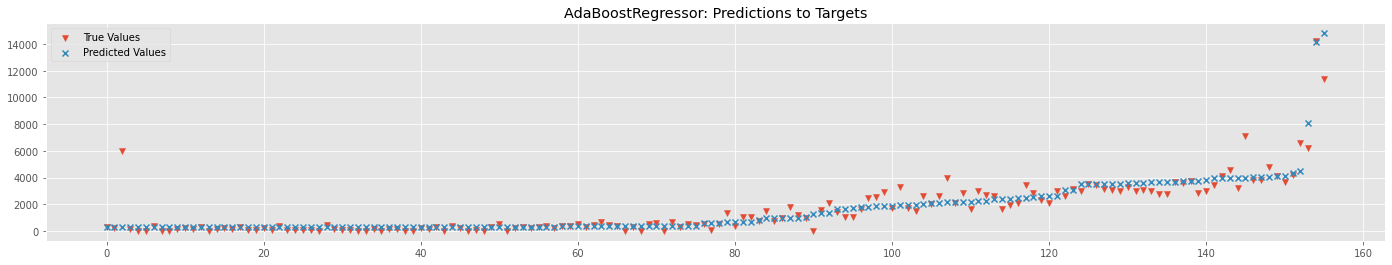

BayesianRidge MAE: 333.90573713844566


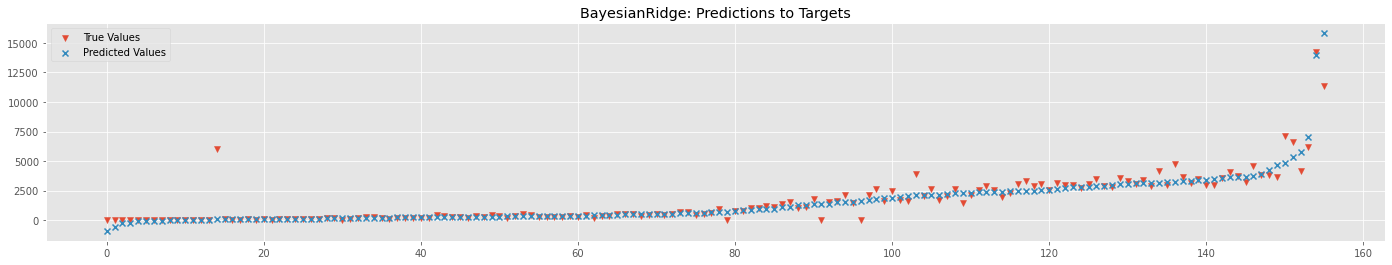

CatBoostRegressor MAE: 330.91761761353115


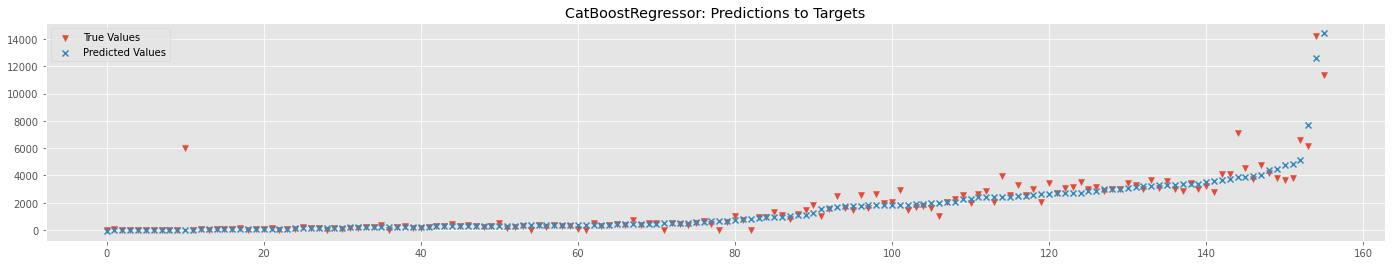

DecisionTreeRegressor MAE: 381.6666666666667


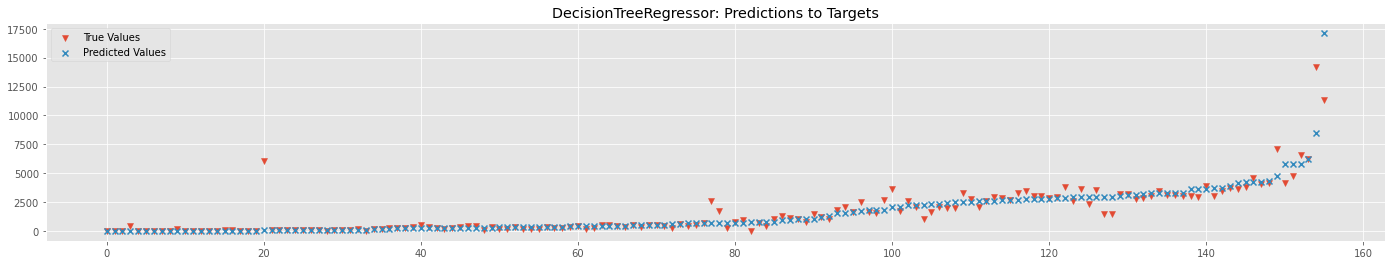

ElasticNet MAE: 342.1503547244021


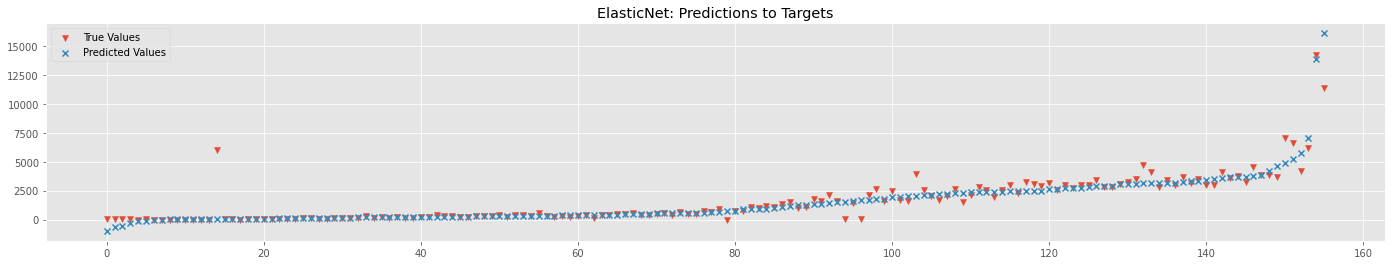

ExtraTreeRegressor MAE: 496.0897435897436


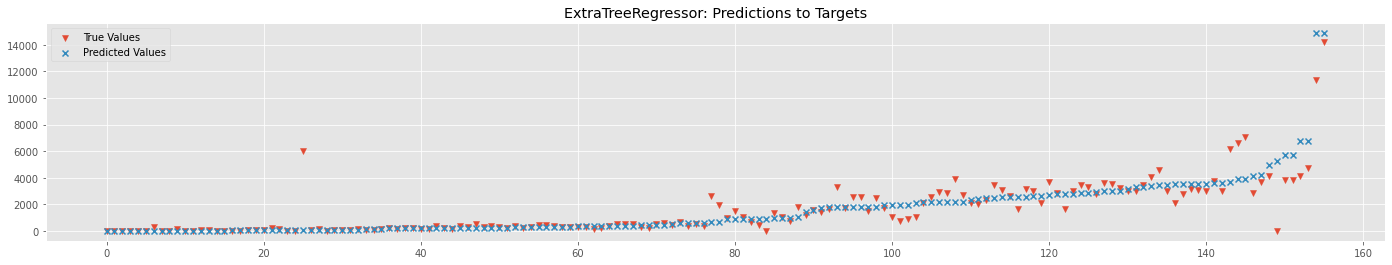

GradientBoostingRegressor MAE: 316.6691884389779


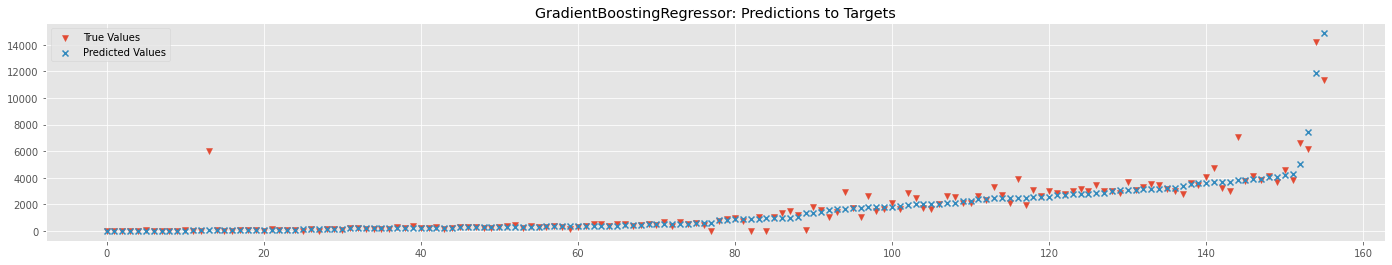

HuberRegressor MAE: 309.29862110714294


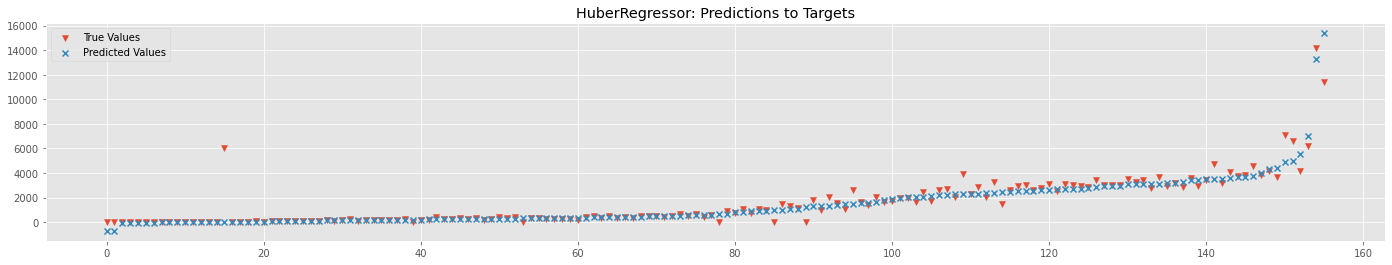

KNeighborsRegressor MAE: 314.54871794871787


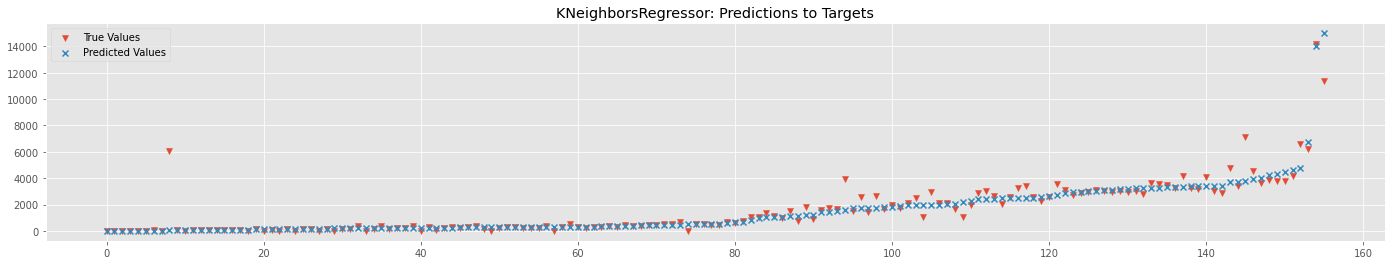

Lars MAE: 393.9302329495709


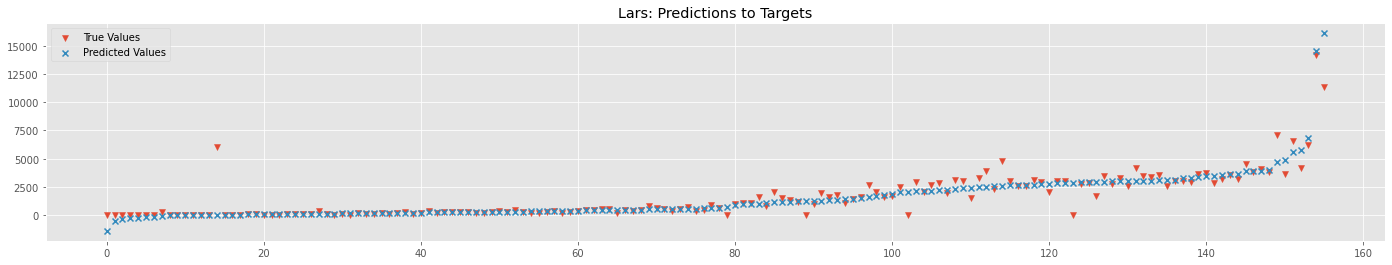

Lasso MAE: 342.14976909086846


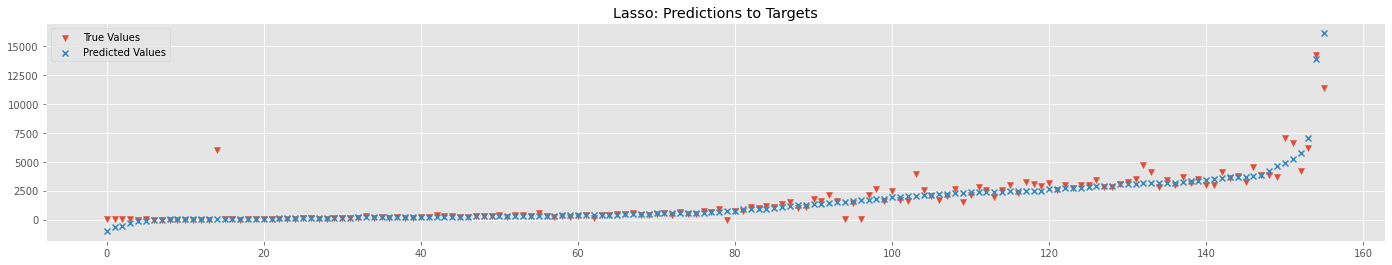

LGBMRegressor MAE: 351.2378640494366


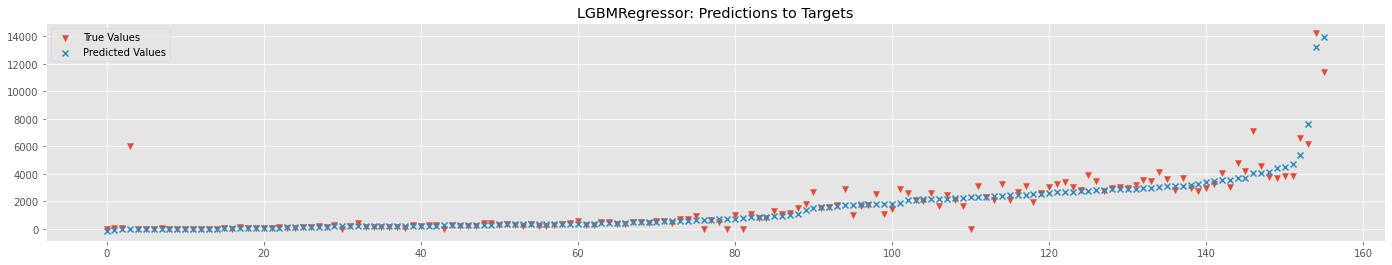

LinearRegression MAE: 342.1551446414678


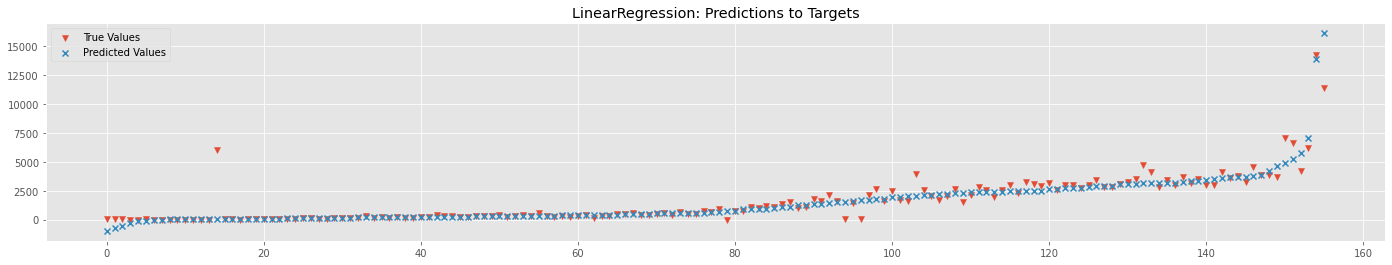

MLPRegressor MAE: 359.39131554617535


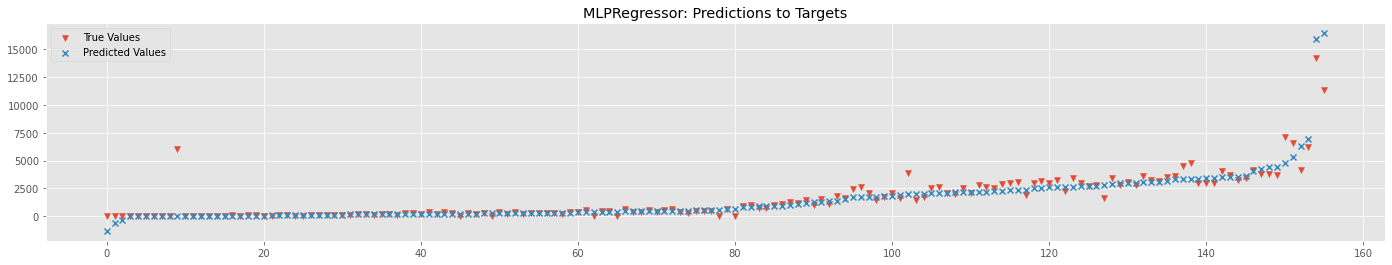

RandomForestRegressor MAE: 306.02833333333336


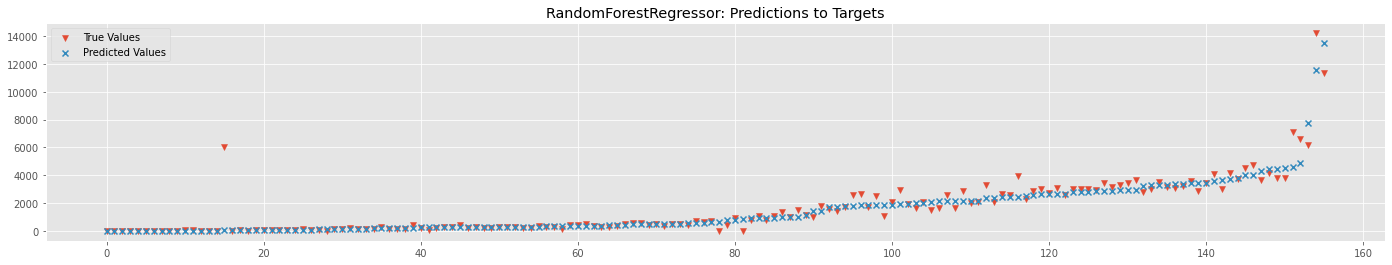

Ridge MAE: 342.1551440019616


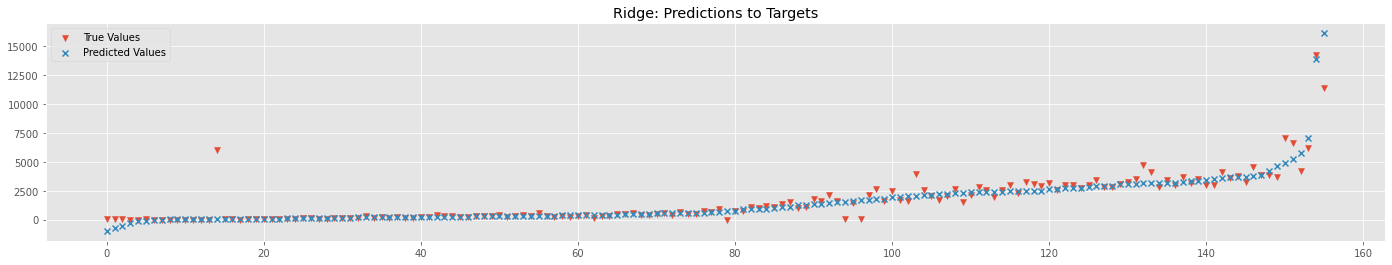

SVR MAE: 1163.4872992996964


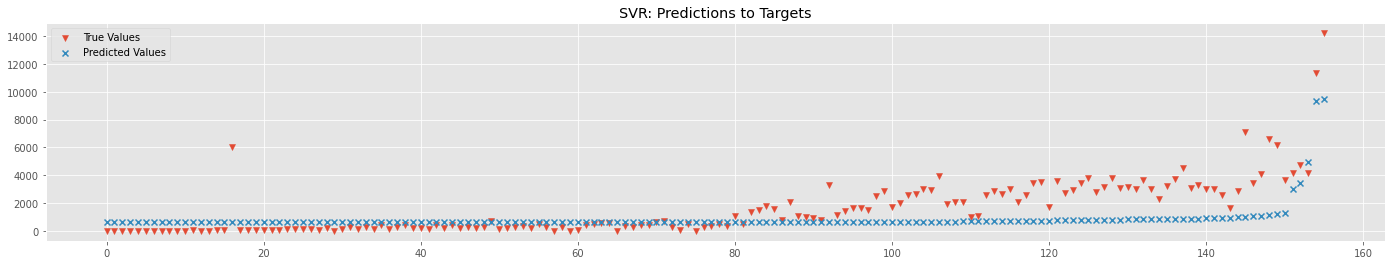

XGBRegressor MAE: 313.24499568734797


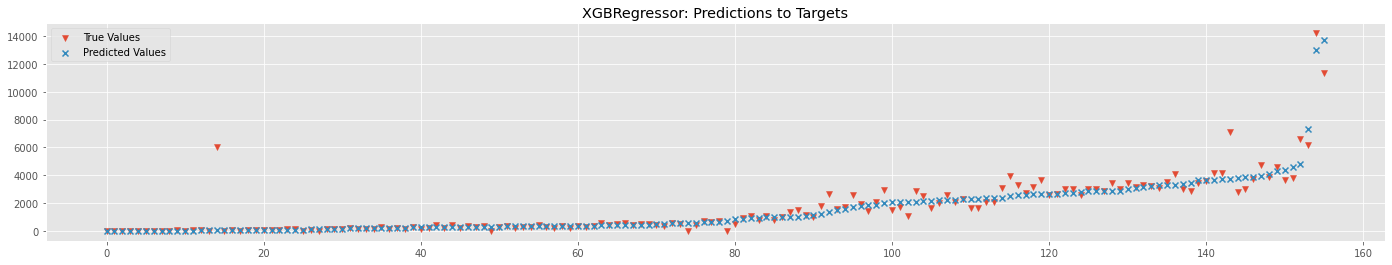

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
get_predictions(AdaBoostRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(BayesianRidge, X_train, X_valid, y_train, y_valid)
get_predictions(CatBoostRegressor, X_train, X_valid, y_train, y_valid, {"verbose": False})
get_predictions(DecisionTreeRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(ElasticNet, X_train, X_valid, y_train, y_valid)
get_predictions(ExtraTreeRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(GradientBoostingRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(HuberRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(KNeighborsRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(Lars, X_train, X_valid, y_train, y_valid)
get_predictions(Lasso, X_train, X_valid, y_train, y_valid)
get_predictions(LGBMRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(LinearRegression, X_train, X_valid, y_train, y_valid)
get_predictions(MLPRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(RandomForestRegressor, X_train, X_valid, y_train, y_valid)
get_predictions(Ridge, X_train, X_valid, y_train, y_valid)
get_predictions(SVR, X_train, X_valid, y_train, y_valid, kernel="poly")
get_predictions(XGBRegressor, X_train, X_valid, y_train, y_valid)

# Forecasting

In [31]:
def forecast(length: int, X, y, model: type = HuberRegressor, init_params:dict = {}, fit_params: dict = {}):
	from copy import deepcopy

	model = model(**init_params)
	model.fit(X, y, **fit_params)

	prediction = []
	X = list(list(deepcopy(X.T))[0][-CONTEXT:])

	for _ in range(length):
		p = model.predict([X])
		prediction.append(p)
		X.append(p)
		X = X[1:]
	
	return [i[0] for i in prediction]

forecast(10, X, y)

[1733.7516077069272,
 1591.2550889273857,
 1570.676174711844,
 2077.081041246781,
 2604.9285103943525,
 1878.5543168544548,
 2511.923983960626,
 1375.2050288942887,
 2170.4003779518107,
 1678.2968714166877]